In [11]:
from neurosynth.base.dataset import Dataset
import nibabel as nib
import numpy as np
from neurosynth.analysis.cluster import Clusterable
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nibabel import nifti1
from copy import deepcopy
from os.path import exists, join, split
from os import makedirs
import pickle
from sklearn import decomposition as sk_decomp
from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt


In [39]:
dataset = Dataset.load('../data/datasets/abs_60topics_filt_jul.pkl')

infile = '../masks/HO_ROIs/MFC/MNI_MFC_30.nii.gz'
saved_pca = '../results/clustering/dv_v5_reference_min_80_pca.pkl'

reference = pickle.load(open(saved_pca, 'r'))

roi = Clusterable(dataset, infile, min_studies=100)

print "Computing roi ref distances"
distances = pairwise_distances(roi.data, reference.data, metric='correlation')

Computing roi ref distances


In [40]:
silhouette = []
outdir = '../results/clustering/MFC_v.6/'
for n_clusters in range(2, 16):
    print "Clustering: " + str(n_clusters)
    clustering_algorithm = KMeans(n_clusters = n_clusters)
    clustering_algorithm.fit(distances) 

    labels = clustering_algorithm.predict(distances) + 1

    # Make nibabel image
    header = roi.masker.get_header()
    header['cal_max'] = labels.max()
    header['cal_min'] = labels.min()
    voxel_labels = np.round(roi.masker.unmask(labels)).astype('int32')
    img = nifti1.Nifti1Image(voxel_labels, None, header)

    if not exists(outdir):
        makedirs(outdir)
        
    outfile = 'MNI_cluster_labels_k%d_v4' % n_clusters

    img.to_filename(join(outdir, outfile))
    silhouette.append([n_clusters, silhouette_score(distances, labels - 1)])

Clustering: 2
Clustering: 3
Clustering: 4
Clustering: 5
Clustering: 6
Clustering: 7
Clustering: 8
Clustering: 9
Clustering: 10
Clustering: 11
Clustering: 12
Clustering: 13
Clustering: 14
Clustering: 15


In [41]:
silhouette = pd.DataFrame(silhouette, columns=['n', 'silhouette'])

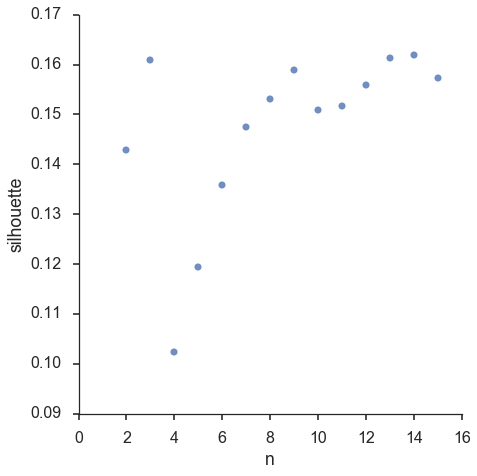

In [42]:
sns.set_context('poster')
sns.set_style('ticks')
sns.despine(left=True)
sns.lmplot('n', 'silhouette', silhouette, fit_reg=False, size=7, legend=False, scatter_kws={"s": 50})
# plt.ylim([0, 0.17])
# plt.xlim([1, 16])
# plt.xticks(range(2, 16))
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Silhouette score')

In [43]:
from nilearn import plotting as niplt

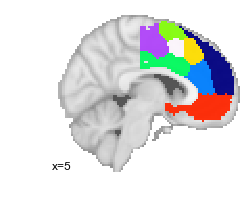

In [44]:
niplt.plot_roi('../results/clustering/MFC_v.6/cluster_labels_k8.nii', cut_coords=[5], draw_cross=False, display_mode='x',  alpha=0.95)